In [152]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import math
from matplotlib.ticker import MaxNLocator
from matplotlib.dates import MonthLocator, YearLocator, DateFormatter
import seaborn as sns
from sklearn import metrics
from sklearn.model_selection import TimeSeriesSplit
from prophet import Prophet
from prophet.diagnostics import cross_validation

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)
plt.style.use('ggplot')

In [153]:
# Read in pre-processed pickle
with open("../data/sfr_mfr_mig_pre-processed.pkl", "rb") as f:
    rpi = pickle.load(f)

In [154]:
rpi = rpi.sort_values(by=['census_cbsa_geoid', 'census_zcta5_geoid', 'date'])
rpi

,date,census_cbsa_geoid,census_zcta5_geoid,sfr_rental_index,sfr_price_index,coef,nounits,occupied_units,mfr_occ,mfr_mean_occ_index,mfr_mean_rent,mfr_mean_rent_index,month,cos_month,sin_month,sfr_rental_delta,sfr_price_delta,mfr_occ_delta,mfr_rental_delta,us_zip,population,student_population_fraction,netflow_estimated,inflow_estimated,outflow_estimated,cumulative_netflow_estimated,median_income_inflow,median_income,median_income_difference,median_age_inflow,median_age,median_age_difference,inflow_index,outflow_index,netflow_index,income_inflow_index,income_diff_index,age_inflow_index,age_inflow_diff_index
0,2010-01-01,12060,30002,100.000000,74.294071,-0.311687,NaN,NaN,NaN,NaN,NaN,NaN,1,8.660254e-01,5.000000e-01,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2010-02-01,12060,30002,102.656397,73.790885,-0.308921,NaN,NaN,NaN,NaN,NaN,NaN,2,5.000000e-01,8.660254e-01,2.656397,-0.503185,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2010-03-01,12060,30002,99.927026,73.500102,-0.329055,NaN,NaN,NaN,NaN,NaN,NaN,3,6.123234e-17,1.000000e+00,-2.729372,-0.290783,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2010-04-01,12060,30002,100.890119,72.837599,-0.330161,NaN,NaN,NaN,NaN,NaN,NaN,4,-5.000000e-01,8.660254e-01,0.963094,-0.662503,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2010-05-01,12060,30002,102.552376,72.728859,-0.311771,NaN,NaN,NaN,NaN,NaN,NaN,5,-8.660254e-01,5.000000e-01,1.662257,-0.108740,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36075,2023-04-01,17460,44333,172.815363,136.885857,0.371038,354.0,349.008,0.985898,100.007450,1207.057143,124.438881,4,-5.000000e-01,8.660254e-01,0.921771,1.030017,0.000000,0.295042,44333,19004.0,0.038,18.0,123.0,105.0,825.0,50757.8516,93292.0,-42534.1484,31.5727,47.4,-15.8273,1.016529,0.690789,-0.580645,0.951640,1.064558,0.917720,1.217803
36076,2023-05-01,17460,44333,174.151339,138.688638,0.373829,354.0,348.008,0.983073,99.720903,1206.419048,124.373098,5,-8.660254e-01,5.000000e-01,1.335976,1.802781,-0.286548,-0.065783,44333,19004.0,0.038,95.0,175.0,80.0,920.0,54563.5039,93292.0,-38728.4961,29.9224,47.4,-17.4776,1.446281,0.526316,-3.064516,1.022991,0.969309,0.869751,1.344782
36077,2023-06-01,17460,44333,174.005400,139.556130,0.360819,354.0,348.008,0.983073,99.720903,1189.680952,122.647521,6,-1.000000e+00,1.224647e-16,-0.145938,0.867492,0.000000,-1.725577,44333,19004.0,0.038,23.0,103.0,80.0,943.0,57836.4570,93292.0,-35455.5430,32.5261,47.4,-14.8739,0.851240,0.526316,-0.741935,1.084354,0.887392,0.945433,1.144445
36078,2023-07-01,17460,44333,175.427516,143.152874,0.425997,NaN,NaN,NaN,NaN,NaN,NaN,7,-8.660254e-01,-5.000000e-01,1.422116,3.596744,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [155]:
# subset relevant columns
df = rpi[['date', 'census_cbsa_geoid', 'census_zcta5_geoid', 'sfr_rental_index', 'sfr_price_index', 'nounits', 'mfr_occ', 'mfr_mean_rent']].copy()

# subset for MFR data time window
df = df.loc[(df.date >= '2015-01-01') & (df.date <= '2023-06-01')]

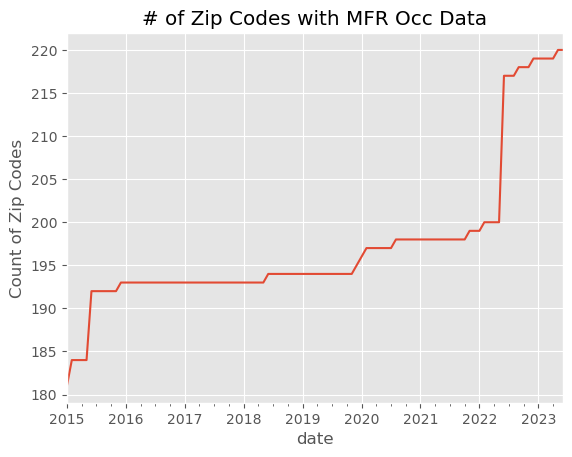

In [156]:
# check for completeness
df.groupby(by='date')['mfr_occ'].count().plot()
plt.title('# of Zip Codes with MFR Occ Data')
plt.ylabel('Count of Zip Codes')
plt.show()

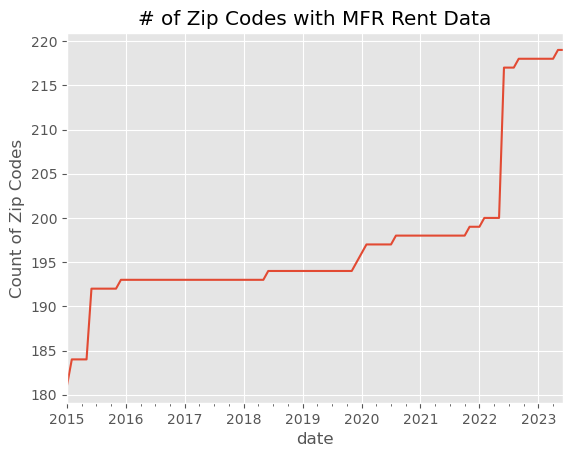

In [157]:
# check for completeness
df.groupby(by='date')['mfr_mean_rent'].count().plot()
plt.title('# of Zip Codes with MFR Rent Data')
plt.ylabel('Count of Zip Codes')
plt.show()

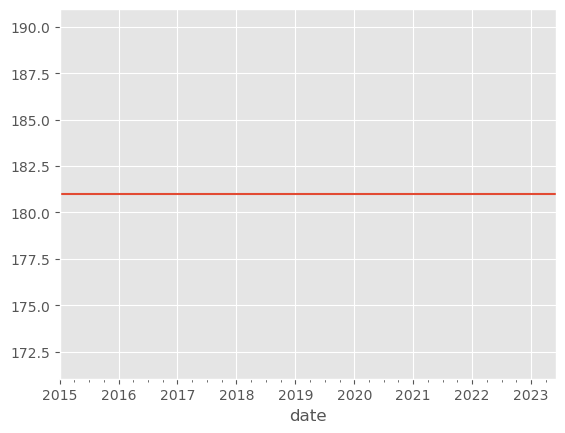

In [158]:
# drop incomplete zips
drops = df.loc[(df.mfr_mean_rent.isna()) | (df.mfr_occ.isna())].census_zcta5_geoid.unique().tolist()
df.drop(df.loc[df['census_zcta5_geoid'].isin(drops)].index, inplace=True)

# check for completeness
df.groupby(by='date')['mfr_occ'].count().plot()
plt.show()

# reset index
df.reset_index(drop=True, inplace=True)

# Prophet Model Function

In [159]:
def prophetize(df, label, y='sfr_rental_index', ds='date', train_start='', test_months=6, addl_reg=[]):
    
    # copy dataframe
    df_p = df.copy()
    
    # rename columns for modeling
    df_p.rename(columns = {
        ds:'ds',
        y:'y'
    }, inplace=True)
        
    # create results dictionary 
    result = {
        'zip_code':[],
        'model':[],
        'mape':[],
        'mae':[],
        'rmse':[]
    }
    
    if train_start == '':
        train_start = df_p['ds'].min()
    
    for z in df_p['census_zcta5_geoid'].unique():
        
        # subset for zip code
        df_z = df_p.loc[(df_p['census_zcta5_geoid'] == z) & (df_p['ds'] >= train_start)]
        
        # determine index value for train/test split based on 'p'
        split_idx = len(df_z) - test_months

        # split data
        train = df_z.iloc[:split_idx]
        test = df_z.iloc[split_idx:]
    
        # instantiate and fit model
        m = Prophet() 
        for r in addl_reg:
            m.add_regressor(r)
        m.fit(train[['ds', 'y'] + addl_reg]) # fit model
        
        # create future dataframe
        future = df_z[['ds'] + addl_reg]
    
        # create forecast
        forecast = m.predict(future)
        
        # calculate MAE and MSE
        mape = metrics.mean_absolute_percentage_error(list(test['y']), list(forecast.loc[split_idx:,'yhat']))
        mae = metrics.mean_absolute_error(list(test['y']), list(forecast.loc[split_idx:,'yhat']))
        rmse = metrics.mean_squared_error(list(test['y']), list(forecast.loc[split_idx:,'yhat']), squared=False)
        
        
        # add to dict
        result['zip_code'].append(z)
        result['model'].append(label)
        result['mape'].append(mape)
        result['mae'].append(mae)
        result['rmse'].append(rmse)
        
        
    return pd.DataFrame.from_dict(result)

# Atlanta - by Zip Code

In [160]:
# subset for Atlanta zip codes
df_atl = df.loc[df['census_cbsa_geoid'] == '12060'].copy()
df_atl.reset_index(drop=True, inplace=True)
df_atl

,date,census_cbsa_geoid,census_zcta5_geoid,sfr_rental_index,sfr_price_index,nounits,mfr_occ,mfr_mean_rent
0,2015-01-01,12060,30002,114.715608,82.331231,592.0,0.910372,650.976648
1,2015-02-01,12060,30002,115.155485,82.202391,592.0,0.910372,666.380495
2,2015-03-01,12060,30002,115.694032,82.423472,592.0,0.912581,653.657967
3,2015-04-01,12060,30002,116.181280,83.115012,592.0,0.907426,654.038462
4,2015-05-01,12060,30002,117.000157,84.135504,592.0,0.907426,645.673077
...,...,...,...,...,...,...,...,...
12031,2023-02-01,12060,30519,188.587234,165.750075,2336.0,0.865714,2062.332814
12032,2023-03-01,12060,30519,189.235967,165.614928,2336.0,0.873572,2069.696914
12033,2023-04-01,12060,30519,189.652129,166.378919,2336.0,0.880706,2060.912826
12034,2023-05-01,12060,30519,190.192039,168.114769,2336.0,0.889595,2062.121936


In [ ]:
# create models with different exogenous features
df1 = prophetize(df_atl, 'Benchmark')
df2 = prophetize(df_atl, 'MFR Occ', addl_reg=['mfr_occ'])
df3 = prophetize(df_atl, 'MFR Rent', addl_reg=['mfr_mean_rent'])
df4 = prophetize(df_atl, 'MFR Occ & Rent', addl_reg=['mfr_mean_rent', 'mfr_occ'])

In [ ]:
# concat results
atl_exo_compare = pd.concat([df1,df2,df3,df4]).reset_index(drop=True)
atl_exo_compare

In [ ]:
# commented out so I don't accidentally overwrite the pickle
# atl_exo_compare.to_pickle('atl_exo_compare.pkl')

In [161]:
# read pickle for compare
with open('atl_exo_compare.pkl', "rb") as f:
    atl_exo_compare = pickle.load(f)
    
atl_exo_compare

,zip_code,model,mape,mae,rmse
0,30002,Benchmark,0.043461,8.329495,8.584817
1,30004,Benchmark,0.047396,8.831550,9.035110
2,30005,Benchmark,0.049286,9.483167,9.703968
3,30008,Benchmark,0.052833,10.881943,11.140033
4,30009,Benchmark,0.052330,10.535776,10.775404
...,...,...,...,...,...
467,30354,MFR Occ & Rent,0.041920,9.421485,10.347888
468,30360,MFR Occ & Rent,0.038098,7.402285,7.633340
469,30363,MFR Occ & Rent,0.035412,11.473550,11.707147
470,30518,MFR Occ & Rent,0.044620,8.576134,8.900997


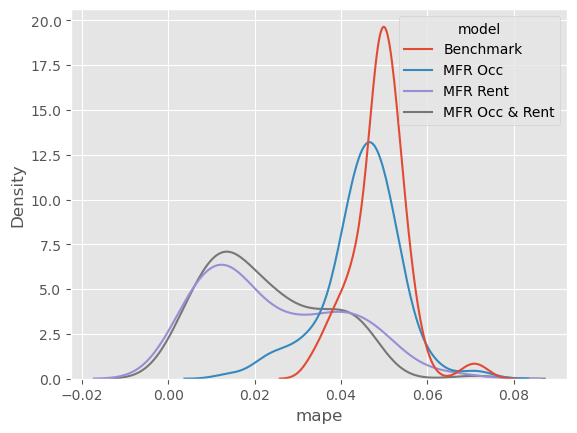

In [163]:
sns.kdeplot(data=atl_exo_compare, x='mape', hue='model')
plt.show()

In [107]:
bar_plot_atl = atl_exo_compare.groupby('model', as_index=False)[['mape','rmse', 'mae']].mean()
bar_plot_atl.sort_values('mape', inplace=True)
bar_plot_atl

,model,mape,rmse,mae
2,MFR Occ & Rent,0.022659,4.871332,4.631700
3,MFR Rent,0.024376,5.218187,4.992659
1,MFR Occ,0.044953,9.411931,9.139289
0,Benchmark,0.049078,10.233656,9.976786


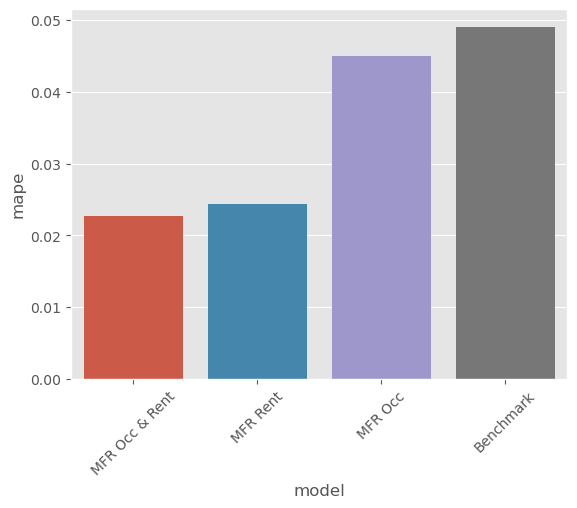

In [108]:
sns.barplot(data=df_box, x='model', y='mape')
plt.xticks(rotation=45)
plt.show()

In [173]:
# run models for different time windows using both exogenous variables
dfa6 = prophetize(dfc, '6 months',  train_start='2022-04-01', addl_reg=['mfr_mean_rent', 'mfr_occ'])
dfa9 = prophetize(dfc, '9 months',  train_start='2022-04-01', addl_reg=['mfr_mean_rent', 'mfr_occ'])
dfa12= prophetize(dfc, '12 months', train_start='2022-01-01', addl_reg=['mfr_mean_rent', 'mfr_occ'])
dfa18= prophetize(dfc, '18 months', train_start='2021-07-01', addl_reg=['mfr_mean_rent', 'mfr_occ'])
dfa24= prophetize(dfc, '24 months', train_start='2021-01-01', addl_reg=['mfr_mean_rent', 'mfr_occ'])
dfa36= prophetize(dfc, '36 months', train_start='2020-01-01', addl_reg=['mfr_mean_rent', 'mfr_occ'])
dfa48= prophetize(dfc, '48 months', train_start='2019-01-01', addl_reg=['mfr_mean_rent', 'mfr_occ'])
dfa72= prophetize(dfc, '72 months', train_start='2017-01-01', addl_reg=['mfr_mean_rent', 'mfr_occ'])

# pull from original model results
dfa96= cle_exo_compare.loc[atl_exo_compare['model'] == 'MFR Occ & Rent'].copy()

# rename model for consitency
dfa96['model'] = '96 months'

In [ ]:
# concat results
atl_train_len_compare = pd.concat([dfa6,dfa9,dfa12,dfa18,dfa24,dfa36,dfa48,dfa72,dfa96]).reset_index(drop=True)
atl_train_len_compare

In [183]:
# commented out so I don't overwrite the pickle
# atl_train_len_compare.to_pickle('atl_train_length_splits.pkl')

In [184]:
with open('atl_train_length_splits.pkl', "rb") as f:
    atl_train_len_compare = pickle.load(f)

In [ ]:
sns.kdeplot(data=atl_train_len_compare[~atl_train_len_compare['model'].isin(['9 months', '6 months'])], x='mape', hue='model')
plt.show()

In [ ]:
barplot_atl_train_split = atl_train_len_compare.groupby('model', as_index=False)[['mape','rmse', 'mae']].mean()
barplot_atl_train_split.sort_values('mape')

In [ ]:
sns.barplot(data=barplot_atl_train_split.sort_values('mape'), x='model', y='mape')
plt.xticks(rotation = 45)
plt.show()

# Cleveland - by Zip Code

In [165]:
# subset for Cleveland zip codes
df_cle = df.loc[df['census_cbsa_geoid'] == '12060'].copy()
df_cle.reset_index(drop=True, inplace=True)
df_cle

,date,census_cbsa_geoid,census_zcta5_geoid,sfr_rental_index,sfr_price_index,nounits,mfr_occ,mfr_mean_rent
0,2015-01-01,12060,30002,114.715608,82.331231,592.0,0.910372,650.976648
1,2015-02-01,12060,30002,115.155485,82.202391,592.0,0.910372,666.380495
2,2015-03-01,12060,30002,115.694032,82.423472,592.0,0.912581,653.657967
3,2015-04-01,12060,30002,116.181280,83.115012,592.0,0.907426,654.038462
4,2015-05-01,12060,30002,117.000157,84.135504,592.0,0.907426,645.673077
...,...,...,...,...,...,...,...,...
12031,2023-02-01,12060,30519,188.587234,165.750075,2336.0,0.865714,2062.332814
12032,2023-03-01,12060,30519,189.235967,165.614928,2336.0,0.873572,2069.696914
12033,2023-04-01,12060,30519,189.652129,166.378919,2336.0,0.880706,2060.912826
12034,2023-05-01,12060,30519,190.192039,168.114769,2336.0,0.889595,2062.121936


In [ ]:
# create models with different exogenous features
dfc1 = prophetize(df_cle, 'Benchmark')
dfc2 = prophetize(df_cle, 'MFR Occ', addl_reg=['mfr_occ'])
dfc3 = prophetize(df_cle, 'MFR Rent', addl_reg=['mfr_mean_rent'])
dfc4 = prophetize(df_cle, 'MFR Occ & Rent', addl_reg=['mfr_mean_rent', 'mfr_occ'])

In [ ]:
# concat results
cle_exo_compare = pd.concat([dfc1,dfc2,dfc3,dfc4]).reset_index(drop=True)
cle_exo_compare

In [ ]:
# commented out so I don't accidentally overwrite the pickle
# cle_exo_compare.to_pickle('cle_exo_compare.pkl')

In [166]:
# read pickle for compare
with open('cle_exo_compare.pkl', "rb") as f:
    cle_exo_compare = pickle.load(f)
    
cle_exo_compare

,zip_code,model,mape,mae,rmse
0,44001,Benchmark,0.023667,4.120750,4.193933
1,44011,Benchmark,0.023848,4.146448,4.205963
2,44012,Benchmark,0.022634,3.915531,3.976931
3,44017,Benchmark,0.024337,4.084813,4.186735
4,44021,Benchmark,0.021434,3.492593,3.667707
...,...,...,...,...,...
247,44212,MFR Occ & Rent,0.016302,2.737510,2.895117
248,44256,MFR Occ & Rent,0.018515,3.125658,3.384487
249,44281,MFR Occ & Rent,0.021997,3.800684,3.959933
250,44321,MFR Occ & Rent,0.009634,1.665188,1.829218


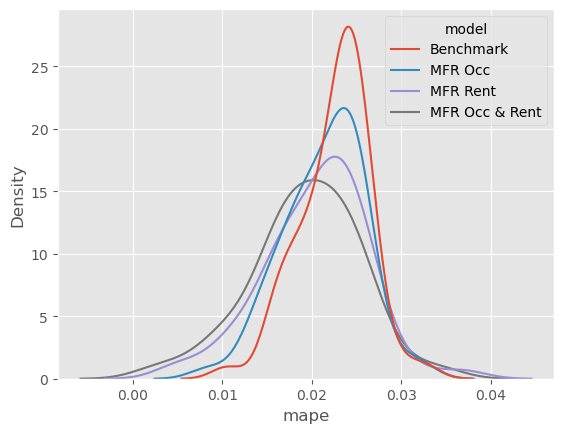

In [167]:
sns.kdeplot(data=cle_exo_compare, x='mape', hue='model')
plt.show()

In [168]:
bar_plot_cle = cle_exo_compare.groupby('model', as_index=False)[['mape','rmse', 'mae']].mean()
bar_plot_cle.sort_values('mape', inplace=True)
bar_plot_cle

,model,mape,rmse,mae
2,MFR Occ & Rent,0.019350,3.468136,3.279389
3,MFR Rent,0.020443,3.650520,3.461084
1,MFR Occ,0.021368,3.771606,3.617384
0,Benchmark,0.022565,3.969770,3.818738


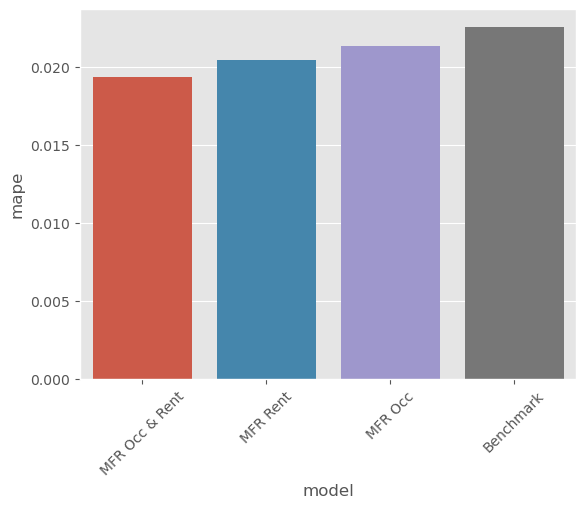

In [169]:
sns.barplot(data=bar_plot_cle, x='model', y='mape')
plt.xticks(rotation=45)
plt.show()

In [173]:
# run models for different time windows using both exogenous variables
dfc6 = prophetize(dfc, '6 months',  train_start='2022-04-01', addl_reg=['mfr_mean_rent', 'mfr_occ'])
dfc9 = prophetize(dfc, '9 months',  train_start='2022-04-01', addl_reg=['mfr_mean_rent', 'mfr_occ'])
dfc12= prophetize(dfc, '12 months', train_start='2022-01-01', addl_reg=['mfr_mean_rent', 'mfr_occ'])
dfc18= prophetize(dfc, '18 months', train_start='2021-07-01', addl_reg=['mfr_mean_rent', 'mfr_occ'])
dfc24= prophetize(dfc, '24 months', train_start='2021-01-01', addl_reg=['mfr_mean_rent', 'mfr_occ'])
dfc36= prophetize(dfc, '36 months', train_start='2020-01-01', addl_reg=['mfr_mean_rent', 'mfr_occ'])
dfc48= prophetize(dfc, '48 months', train_start='2019-01-01', addl_reg=['mfr_mean_rent', 'mfr_occ'])
dfc72= prophetize(dfc, '72 months', train_start='2017-01-01', addl_reg=['mfr_mean_rent', 'mfr_occ'])

# pull from original model results
dfc96= cle_exo_compare.loc[cle_exo_compare['model'] == 'MFR Occ & Rent'].copy()

# rename model for consistency
dfc96['model'] = '96 months'

In [ ]:
cle_train_len_compare = pd.concat([dfc6,dfc9,dfc12,dfc18,dfc24,dfc36,dfc48,dfc72,dfc96]).reset_index(drop=True)
cle_train_len_compare

In [183]:
# commented out so I don't overwrite the pickle
# cle_train_len_compare.to_pickle('cle_train_length_splits.pkl')

In [184]:
with open('cle_train_length_splits.pkl', "rb") as f:
    cle_train_len_compare = pickle.load(f)

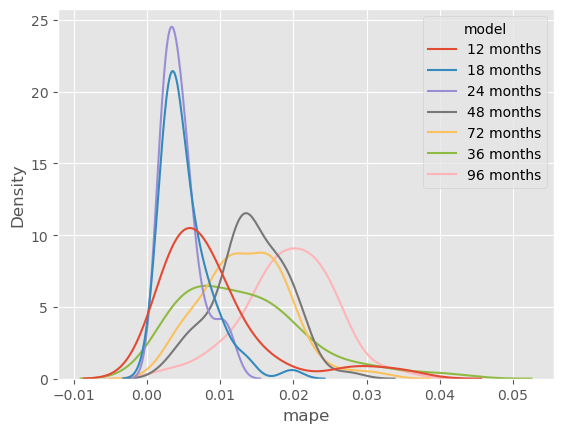

In [187]:
sns.kdeplot(data=cle_train_len_compare[~cle_train_len_compare['model'].isin(['9 months', '6 months'])], x='mape', hue='model')
plt.show()

In [189]:
barplot_cle_train_split = cle_train_len_compare.groupby('model', as_index=False)[['mape','rmse', 'mae']].mean()
barplot_cle_train_split.sort_values('mape')

,model,mape,rmse,mae
2,24 months,0.004622,0.922357,0.781251
1,18 months,0.005275,1.054177,0.887308
0,12 months,0.008970,1.795358,1.513731
3,36 months,0.013249,2.519153,2.212742
6,72 months,0.013512,2.486436,2.300685
4,48 months,0.014209,2.679511,2.393077
7,9 months,0.017906,3.503629,2.955963
8,96 months,0.019350,3.468136,3.279389
5,6 months,0.031166,6.540402,5.211837


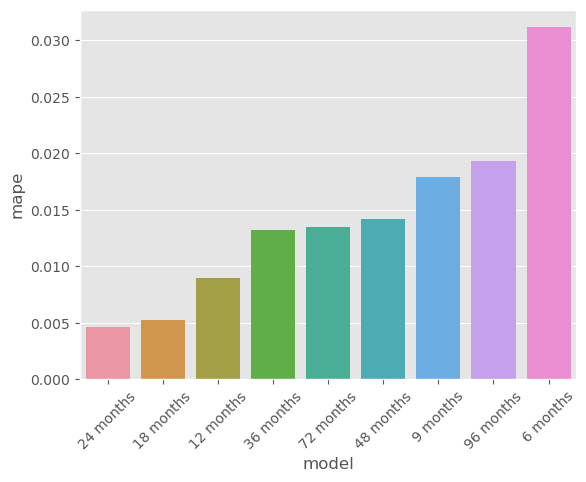

In [191]:
sns.barplot(data=barplot_cle_train_split.sort_values('mape'), x='model', y='mape')
plt.xticks(rotation = 45)
plt.show()

# Cross Val

In [90]:
create time series 
class BlockingTimeSeriesSplit():
    def __init__(self, n_splits):
        self.n_splits = n_splits
    
    def get_n_splits(self, X, y, groups):
        return self.n_splits
    
    def split(self, X, y=None, groups=None):
        n_samples = len(X)
        k_fold_size = 18 # need to update so that this is an input
        indices = np.arange(n_samples)

        margin = 0
        for i in range(self.n_splits):
            start = i * k_fold_size
            stop = start + k_fold_size
            mid = start + 12 # need to update so that this an input
            yield indices[start: mid], indices[mid + margin: stop]

In [91]:
cv = BlockingTimeSeriesSplit(n_splits=5)

In [100]:
cv = BlockingTimeSeriesSplit(n_splits=5)
for zip in df['census_zcta5_geoid'].unique():
    df_z = df[df['census_zcta5_geoid'] == zip]
    for ii, (tr,tt) in enumerate(cv.split(test)):
        print(df_z.iloc[tr])
        print(df_z.iloc[tt])

         date census_cbsa_geoid census_zcta5_geoid  sfr_rental_index  \
0  2015-01-01             12060              30002        114.715608   
1  2015-02-01             12060              30002        115.155485   
2  2015-03-01             12060              30002        115.694032   
3  2015-04-01             12060              30002        116.181280   
4  2015-05-01             12060              30002        117.000157   
5  2015-06-01             12060              30002        117.694274   
6  2015-07-01             12060              30002        118.532039   
7  2015-08-01             12060              30002        118.931005   
8  2015-09-01             12060              30002        119.396981   
9  2015-10-01             12060              30002        119.758586   
10 2015-11-01             12060              30002        119.941588   
11 2015-12-01             12060              30002        120.148648   

    sfr_price_index  nounits   mfr_occ  mfr_mean_rent  
0      

           date census_cbsa_geoid census_zcta5_geoid  sfr_rental_index  \
1326 2015-01-01             12060              30033        115.418056   
1327 2015-02-01             12060              30033        115.851914   
1328 2015-03-01             12060              30033        116.337972   
1329 2015-04-01             12060              30033        116.827236   
1330 2015-05-01             12060              30033        117.555555   
1331 2015-06-01             12060              30033        118.183114   
1332 2015-07-01             12060              30033        118.913652   
1333 2015-08-01             12060              30033        119.259434   
1334 2015-09-01             12060              30033        119.644924   
1335 2015-10-01             12060              30033        119.932938   
1336 2015-11-01             12060              30033        120.068144   
1337 2015-12-01             12060              30033        120.228708   

      sfr_price_index  nounits   mfr_

           date census_cbsa_geoid census_zcta5_geoid  sfr_rental_index  \
2652 2015-01-01             12060              30058        112.589412   
2653 2015-02-01             12060              30058        113.069038   
2654 2015-03-01             12060              30058        113.716259   
2655 2015-04-01             12060              30058        114.210226   
2656 2015-05-01             12060              30058        115.157528   
2657 2015-06-01             12060              30058        115.913307   
2658 2015-07-01             12060              30058        116.898116   
2659 2015-08-01             12060              30058        117.409540   
2660 2015-09-01             12060              30058        117.990929   
2661 2015-10-01             12060              30058        118.489964   
2662 2015-11-01             12060              30058        118.786693   
2663 2015-12-01             12060              30058        119.060106   

      sfr_price_index  nounits   mfr_

           date census_cbsa_geoid census_zcta5_geoid  sfr_rental_index  \
3264 2015-01-01             12060              30068        114.328996   
3265 2015-02-01             12060              30068        114.746043   
3266 2015-03-01             12060              30068        115.344408   
3267 2015-04-01             12060              30068        115.891822   
3268 2015-05-01             12060              30068        116.690193   
3269 2015-06-01             12060              30068        117.383976   
3270 2015-07-01             12060              30068        118.207582   
3271 2015-08-01             12060              30068        118.681301   
3272 2015-09-01             12060              30068        119.130709   
3273 2015-10-01             12060              30068        119.476239   
3274 2015-11-01             12060              30068        119.699851   
3275 2015-12-01             12060              30068        119.944878   

      sfr_price_index  nounits   mfr_

           date census_cbsa_geoid census_zcta5_geoid  sfr_rental_index  \
7122 2022-01-01             12060              30252        191.717395   
7123 2022-02-01             12060              30252        193.013392   
7124 2022-03-01             12060              30252        194.490964   
7125 2022-04-01             12060              30252        196.100652   
7126 2022-05-01             12060              30252        197.752780   
7127 2022-06-01             12060              30252        199.452545   

      sfr_price_index  nounits  mfr_occ  mfr_mean_rent  
7122       145.172532    264.0    0.924    1484.401122  
7123       146.626595    264.0    0.917    1488.526531  
7124       148.340810    264.0    0.913    1486.337249  
7125       150.997049    264.0    0.905    1484.147966  
7126       153.567141    264.0    0.898    1481.958684  
7127       155.965284    264.0    0.890    1479.721190  
           date census_cbsa_geoid census_zcta5_geoid  sfr_rental_index  \
7140 201

           date census_cbsa_geoid census_zcta5_geoid  sfr_rental_index  \
8466 2015-01-01             12060              30308        115.729709   
8467 2015-02-01             12060              30308        116.212915   
8468 2015-03-01             12060              30308        116.687151   
8469 2015-04-01             12060              30308        117.163344   
8470 2015-05-01             12060              30308        117.869122   
8471 2015-06-01             12060              30308        118.498211   
8472 2015-07-01             12060              30308        119.172443   
8473 2015-08-01             12060              30308        119.451419   
8474 2015-09-01             12060              30308        119.770818   
8475 2015-10-01             12060              30308        120.009125   
8476 2015-11-01             12060              30308        120.078307   
8477 2015-12-01             12060              30308        120.242804   

      sfr_price_index  nounits   mfr_

            date census_cbsa_geoid census_zcta5_geoid  sfr_rental_index  \
11118 2015-01-01             12060              30345        115.458062   
11119 2015-02-01             12060              30345        115.874326   
11120 2015-03-01             12060              30345        116.396482   
11121 2015-04-01             12060              30345        116.913088   
11122 2015-05-01             12060              30345        117.668902   
11123 2015-06-01             12060              30345        118.300438   
11124 2015-07-01             12060              30345        119.060009   
11125 2015-08-01             12060              30345        119.458281   
11126 2015-09-01             12060              30345        119.865852   
11127 2015-10-01             12060              30345        120.179495   
11128 2015-11-01             12060              30345        120.347544   
11129 2015-12-01             12060              30345        120.530930   

       sfr_price_index  

            date census_cbsa_geoid census_zcta5_geoid  sfr_rental_index  \
14142 2020-07-01             17460              44105        151.780143   
14143 2020-08-01             17460              44105        153.389030   
14144 2020-09-01             17460              44105        155.195244   
14145 2020-10-01             17460              44105        156.580524   
14146 2020-11-01             17460              44105        156.988904   
14147 2020-12-01             17460              44105        158.059391   

       sfr_price_index  nounits  mfr_occ  mfr_mean_rent  
14142        97.962572    144.0    0.993     625.058824  
14143        99.693701    144.0    0.993     627.058824  
14144       100.756679    144.0    0.993     629.058824  
14145       101.869741    144.0    0.993     632.058824  
14146       103.905902    144.0    0.986     632.294118  
14147       105.035730    144.0    0.986     632.529412  
            date census_cbsa_geoid census_zcta5_geoid  sfr_rental_in

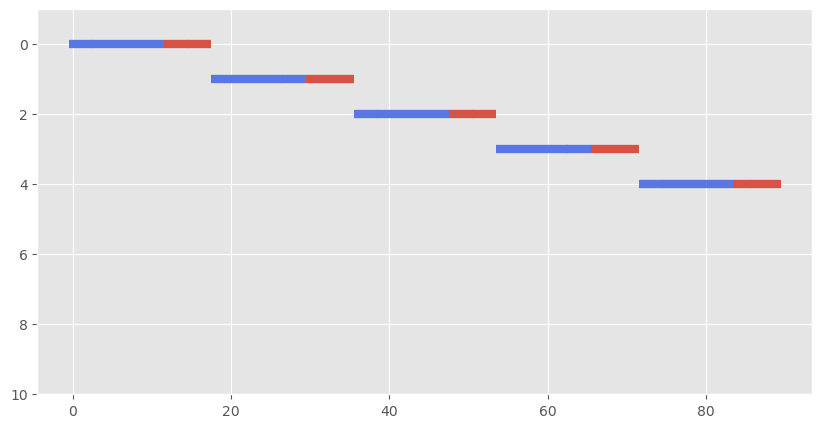

In [89]:
fig, ax = plt.subplots(figsize=(10,5))
for ii, (tr,tt) in enumerate(cv.split(test)):
    l1 = ax.scatter(tr, [ii] * len(tr), c=[plt.cm.coolwarm(.1)], marker='_', lw=6)
    l2 = ax.scatter(tt, [ii] * len(tt), c=[plt.cm.coolwarm(.9)], marker='_', lw=6)
    ax.set(ylim=[10, -1])

# below here is IN PROGRESS... will upload later this weekend after it all runs

## not currently functional

In [125]:
def prophetize_cv(df, label, y='sfr_rental_index', ds='date', addl_reg=[]):
    
    # copy dataframe
    df_p = df.copy()
    
    # rename columns for modeling
    df_p.rename(columns = {
        ds:'ds',
        y:'y'
    }, inplace=True)
        
    # create results dictionary 
    result = {
        'zip_code':[],
        'model':[],
        'mape':[],
        'mae':[],
        'rmse':[]
    }
    
    for z in df_p['census_zcta5_geoid'].unique():
                
        # subset for zip code
        df_z = df_p.loc[(df_p['census_zcta5_geoid'] == z)]
        
        for ii , (tr, tt) in enumerate(cv.split(df_z)):
            
            train = df_z.iloc[tr]
            test = df_z.iloc[tt]
            
            # instantiate and fit model
            m = Prophet() 
            for r in addl_reg:
                m.add_regressor(r)
            m.fit(train[['ds', 'y'] + addl_reg]) # fit model

            # create future dataframe
            future = df_z[['ds'] + addl_reg]

            # create forecast
            forecast = m.predict(future)

            # calculate MAE and MSE
            mape = metrics.mean_absolute_percentage_error(list(test['y']), list(forecast.loc[tt,'yhat']))
            mae = metrics.mean_absolute_error(list(test['y']), list(forecast.loc[tt,'yhat']))
            rmse = metrics.mean_squared_error(list(test['y']), list(forecast.loc[tt,'yhat']), squared=False)
            
            print(mape)
            break

        # add to dict
        result['zip_code'].append(z)
        result['model'].append(label)
        result['mape'].append(mape)
        result['mae'].append(mae)
        result['rmse'].append(rmse)
        
        
    return pd.DataFrame.from_dict(result)